## Import Libraries

### Python Libraries

In [1]:
from datetime import datetime

### External Libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn

### Custom Libraries

In [3]:
from utils_random import set_random_seed
from utils_io import read_bitarrays
from utils_torch.data import stratified_random_split
from utils_attacker_lstm.data import DatasetAttackerLSTMPool, DataLoaderAttackerLSTM
from utils_attacker_lstm.models import ModelAttackerConvLSTMLinear, TrainerAttackerLSTM, TesterAttackerLSTM, ManagerAttackerLSTM
from utils_plot import plot_train_eval_loss_accuracy, plot_receiver_operating_characteristics_curve, plot_confusion_matrix

## Set Parameters

### Model Id

In [4]:
model_id = datetime.now().strftime('%m%d%H%M')

In [5]:
random_seed = 42

### Data Params

In [6]:
num_snps = 80000
train_eval_test_split = [0.7, 0.15, 0.15]

### Loader Params

In [7]:
genome_batch_size = 32
snp_batch_size = 80000

### Model Params

#### Conv1d Params

In [8]:
conv_num_layers = 3
conv_channel_size = [3, 4, 8, 4]
conv_kernel_size = [20, 10, 10]
conv_stride = [2, 2, 2]
conv_dilation = [1, 1, 1]
conv_groups = [1, 1, 1]

conv_activation = [nn.ReLU, nn.ReLU]
conv_activation_kwargs = [{}, {}]

conv_dropout_p = [0.5, 0.5]
conv_dropout_first = [True, True]

conv_batch_norm = [True, True]
conv_batch_norm_momentum = [0.1, 0.1]

#### Conv1d to LSTM Params

In [9]:
conv_lstm_activation = nn.ReLU
conv_lstm_activation_kwargs = {}
conv_lstm_dropout_p = 0.50
conv_lstm_dropout_first = True
conv_lstm_layer_norm = False

#### LSTM Params

In [10]:
lstm_num_layers = 1
lstm_input_size = 4
lstm_hidden_size = [8]
lstm_proj_size = [0]
lstm_bidirectional = [True]

lstm_dropout_p = []
lstm_dropout_first = []

lstm_layer_norm = []

#### LSTM to Linear Params

In [11]:
lstm_linear_dropout_p = 0.25
lstm_linear_dropout_first = True

lstm_linear_batch_norm = True
lstm_linear_batch_norm_momentum = 0.1

#### Linear Params

In [12]:
linear_num_layers = 1
linear_num_features = [16, 1]

linear_activation = []
linear_activation_kwargs = []

linear_dropout_p = []
linear_dropout_first = []

linear_batch_norm = []
linear_batch_norm_momentum = []

### Trainer Params

In [13]:
num_epochs = 256
learning_rate = 0.001

## Set Torch Device

In [14]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Set Random Seed

In [15]:
set_random_seed(random_seed)

## Load Data

### Load Genomes

In [16]:
genomes_pool = read_bitarrays('../data/test/In_Pop.pkl')[:, :num_snps]
genomes_reference = read_bitarrays('../data/test/Not_In_Pop.pkl')[:, :num_snps]
genomes = np.concatenate((genomes_pool, genomes_reference), axis=0)

### Load Labels

In [17]:
labels_beacon = np.ones(genomes_pool.shape[0], dtype=bool)
labels_reference = np.zeros(genomes_reference.shape[0], dtype=bool)
labels = np.concatenate((labels_beacon, labels_reference), axis=0).astype(bool)

### Compute Frequencies

In [18]:
frequencies_pool = np.mean(genomes_pool, axis=0)
frequencies_reference = np.mean(genomes_reference, axis=0)

## Create Dataset

In [19]:
dataset = DatasetAttackerLSTMPool(
    target_genomes=genomes,
    pool_frequencies=frequencies_pool,
    reference_frequencies=frequencies_reference,
    targets=labels)
subset_train, subset_eval, subset_test = stratified_random_split(dataset, train_eval_test_split)

## Create DataLoaders

In [20]:
loader_train = DataLoaderAttackerLSTM(subset_train, genome_batch_size, snp_batch_size, shuffle=True)
loader_eval = DataLoaderAttackerLSTM(subset_eval, genome_batch_size, snp_batch_size, shuffle=False)
loader_test = DataLoaderAttackerLSTM(subset_test, genome_batch_size, snp_batch_size, shuffle=False)

## Create Model

In [21]:
model = ModelAttackerConvLSTMLinear(
    conv_num_layers=conv_num_layers,
    conv_channel_size=conv_channel_size,
    conv_kernel_size=conv_kernel_size,
    conv_stride=conv_stride,
    conv_dilation=conv_dilation,
    conv_groups=conv_groups,
    conv_activation=conv_activation,
    conv_activation_kwargs=conv_activation_kwargs,
    conv_dropout_p=conv_dropout_p,
    conv_dropout_first=conv_dropout_first,
    conv_batch_norm=conv_batch_norm,
    conv_batch_norm_momentum=conv_batch_norm_momentum,
    conv_lstm_activation=conv_lstm_activation,
    conv_lstm_activation_kwargs=conv_lstm_activation_kwargs,
    conv_lstm_dropout_p=conv_lstm_dropout_p,
    conv_lstm_dropout_first=conv_lstm_dropout_first,
    conv_lstm_layer_norm=conv_lstm_layer_norm,
    lstm_num_layers=lstm_num_layers,
    lstm_input_size=lstm_input_size,
    lstm_hidden_size=lstm_hidden_size,
    lstm_proj_size=lstm_proj_size,
    lstm_bidirectional=lstm_bidirectional,
    lstm_dropout_p=lstm_dropout_p,
    lstm_dropout_first=lstm_dropout_first,
    lstm_layer_norm=lstm_layer_norm,
    lstm_linear_dropout_p=lstm_linear_dropout_p,
    lstm_linear_dropout_first=lstm_linear_dropout_first,
    lstm_linear_batch_norm=lstm_linear_batch_norm,
    lstm_linear_batch_norm_momentum=lstm_linear_batch_norm_momentum,
    linear_num_layers=linear_num_layers,
    linear_num_features=linear_num_features,
    linear_activation=linear_activation,
    linear_activation_kwargs=linear_activation_kwargs,
    linear_dropout_p=linear_dropout_p,
    linear_dropout_first=linear_dropout_first,
    linear_batch_norm=linear_batch_norm,
    linear_batch_norm_momentum=linear_batch_norm_momentum
)
model.to(device)

ModelAttackerConvLSTMLinear(
  (lstm_modules): MultiLayerLSTM(
    (_lstm_modules): ModuleList(
      (0): LSTM(4, 8, batch_first=True, bidirectional=True)
    )
    (_dropout_modules): ModuleList()
    (_layer_norm_modules): ModuleList()
  )
  (lstm_linear_dropout_module): Dropout(p=0.25, inplace=False)
  (lstm_linear_batch_norm_module): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_modules): MultiLayerLinear(
    (_multi_layer_modules): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (conv_modules): MultiLayerConv1d(
    (_multi_layer_modules): Sequential(
      (0): Conv1d(3, 4, kernel_size=(20,), stride=(2,))
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv1d(4, 8, kernel_size=(10,), stride=(2,))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): BatchNorm1d(8, eps=1e-0

## Create Trainer

### Create Criterion and Optimizer

In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Create Trainer

In [23]:
trainer = TrainerAttackerLSTM(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=loader_train,
    eval_loader=loader_eval,
    device=device,
    max_grad_norm=1.0,
    norm_type=2
)

## Create Tester

In [24]:
tester = TesterAttackerLSTM(
    model=model,
    criterion=criterion,
    test_loader=loader_test,
    device=device
)

## Create Manager

In [25]:
manager = ManagerAttackerLSTM(
    models_dir='../models/',
    models_file='models.csv'
)

## Train Model

### Train Model

In [26]:
trainer.train(num_epochs=num_epochs, verbose=True)

Epoch 1/256
Train Loss: 0.7073, Train Accuracy: 0.54
Evaluation Loss: 0.6956, Evaluation Accuracy: 0.50
Evaluation Loss Decreased: inf -> 0.6956. Saving Model...
Epoch 2/256
Train Loss: 0.7375, Train Accuracy: 0.47
Evaluation Loss: 0.6971, Evaluation Accuracy: 0.50
Epoch 3/256
Train Loss: 0.7412, Train Accuracy: 0.46
Evaluation Loss: 0.7005, Evaluation Accuracy: 0.50
Epoch 4/256
Train Loss: 0.7213, Train Accuracy: 0.51
Evaluation Loss: 0.6983, Evaluation Accuracy: 0.50
Epoch 5/256
Train Loss: 0.7027, Train Accuracy: 0.52
Evaluation Loss: 0.6975, Evaluation Accuracy: 0.50
Epoch 6/256
Train Loss: 0.7233, Train Accuracy: 0.48
Evaluation Loss: 0.6989, Evaluation Accuracy: 0.50
Epoch 7/256
Train Loss: 0.7037, Train Accuracy: 0.52
Evaluation Loss: 0.7004, Evaluation Accuracy: 0.50
Epoch 8/256
Train Loss: 0.7138, Train Accuracy: 0.51
Evaluation Loss: 0.6982, Evaluation Accuracy: 0.50
Epoch 9/256
Train Loss: 0.6999, Train Accuracy: 0.53
Evaluation Loss: 0.6974, Evaluation Accuracy: 0.50
Epoch 

### Print Metrics

In [27]:
finish_time = datetime.now()
best_eval_loss_epoch = trainer.best_eval_loss_epoch
best_eval_loss = trainer.best_eval_loss
best_eval_accuracy = trainer.eval_accuracies[best_eval_loss_epoch]

print(f'Finished training at {finish_time}')
print(f'Best evaluation loss epoch found at: {best_eval_loss_epoch}')
print(f'Best evaluation loss found: {best_eval_loss:.4f}')
print(f'Best evaluation accuracy found: {best_eval_accuracy:.4f}')

Finished training at 2024-11-07 18:59:53.968447
Best evaluation loss epoch found at: 16
Best evaluation loss found: 0.6943
Best evaluation accuracy found: 0.5000


### Plot Metrics

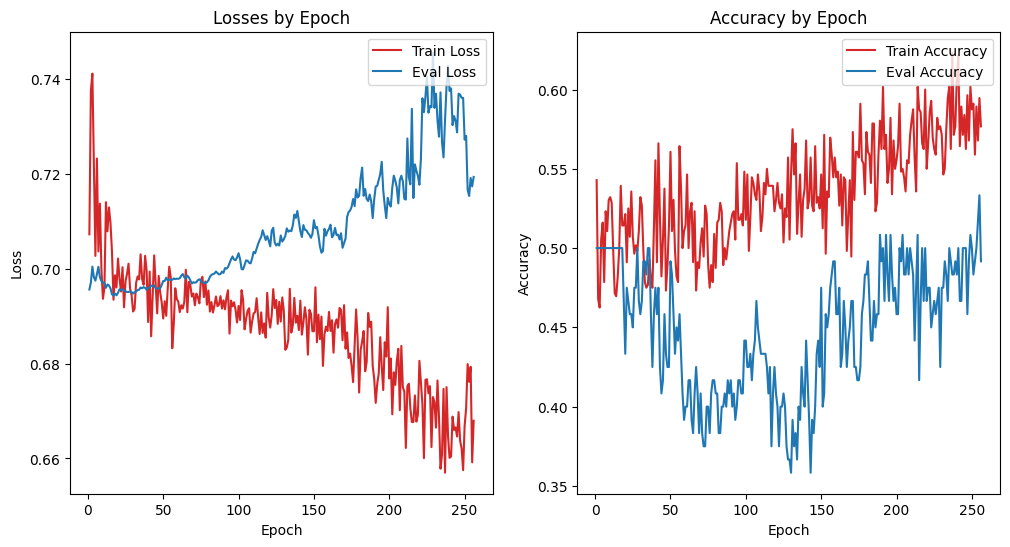

In [28]:
plot_train_eval_loss_accuracy(train_loss=trainer.train_losses,
                              train_accuracy=trainer.train_accuracies,
                              eval_loss=trainer.eval_losses,
                              eval_accuracy=trainer.eval_accuracies)

## Test Model

### Test Model

In [29]:
tester.test()

### Print Metrics

In [30]:
print(f'Test loss: {tester.loss:.4f}')
print(f'Test accuracy: {tester.accuracy_score:.2f}')
print(f'Test precision: {tester.precision_score:.2f}')
print(f'Test recall: {tester.recall_score:.2f}')
print(f'Test f1: {tester.f1_score:.2f}')
print(f'Test AUC: {tester.auroc_score:.2f}')

Test loss: 0.6947
Test accuracy: 0.50
Test precision: 0.50
Test recall: 1.00
Test f1: 0.67
Test AUC: 0.50


### Plot ROC Curve

In [ ]:
fpr, tpr, _ = tester.roc_curve
plot_receiver_operating_characteristics_curve(false_positive_rates=fpr,
                                              true_positive_rates=tpr,
                                              auc=tester.auroc_score)

### Plot Confusion Matrix

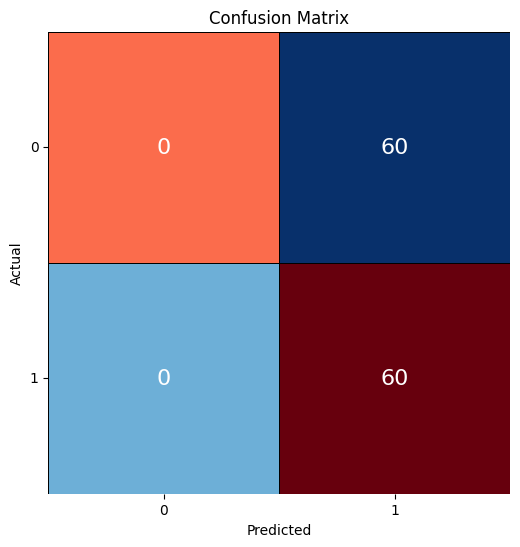

In [31]:
plot_confusion_matrix(tester.confusion_matrix_scores)

## Save Model


In [32]:
manager.add_model(
    model_id=model_id,
    random_seed=random_seed,
    data=dataset,
    loader=loader_train,
    model=model,
    trainer=trainer,
    tester=tester
)